# Model Comparison: Predicting Beats-per-Minute (BPM)

This notebook trains and compares several regression models (Random Forest, XGBoost if available, and MLP) for predicting song BPM. It prefers processed CSVs in `data/processed/` and falls back to `data/raw/`. It will attempt to reuse `src.data_preprocessing` and `src.feature_engineering` if present; otherwise it uses a safe numeric-only preprocessing fallback.

Open the notebook and run cells top-to-bottom. The notebook is runnable in a Python 3 kernel.

In [1]:
# Imports and utilities
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

print('Imports ok')

# Robust loader that prefers processed files
def load_csv(preferred_path: str, fallback_path: str) -> pd.DataFrame:
    if Path(preferred_path).exists():
        print(f'Loading {preferred_path}')
        return pd.read_csv(preferred_path)
    if Path(fallback_path).exists():
        print(f'Loading fallback {fallback_path}')
        return pd.read_csv(fallback_path)
    raise FileNotFoundError(f'Neither {preferred_path} nor {fallback_path} exist')

# Small helper to ensure numeric-only features and align columns
def prepare_numeric(X: pd.DataFrame, ref_columns=None) -> pd.DataFrame:
    X_num = X.select_dtypes(include=[np.number]).copy()
    X_num = X_num.fillna(0)
    if ref_columns is not None:
        X_num = X_num.reindex(columns=ref_columns, fill_value=0)
    return X_num

print('Helpers ready')


Imports ok
Helpers ready


In [5]:
# Ensure working directory is the repository root so relative data paths work
from pathlib import Path
ROOT = Path('/home/dobercode/Predicting-the-Beats-per-Minute-of-Songs')
import os
os.chdir(ROOT)
print('Changed cwd to', Path.cwd())


Changed cwd to /home/dobercode/Predicting-the-Beats-per-Minute-of-Songs


In [7]:
# Load datasets (prefer processed)
try:
    train_df = load_csv('data/processed/train_experimental.csv', 'data/raw/train.csv')
    test_df = load_csv('data/processed/test_experimental.csv', 'data/raw/test.csv')
except Exception as e:
    print('Primary paths not found, trying raw-only:', e)
    train_df = load_csv('data/raw/train.csv', 'data/raw/train.csv')
    test_df = load_csv('data/raw/test.csv', 'data/raw/test.csv')

print('train shape:', train_df.shape, 'test shape:', test_df.shape)

# Try using project-specific preprocessing/feature engineering
X_train = None
X_test = None
y_train = None
y_test = None

try:
    from src.data_preprocessing import preprocess_data
    from src.feature_engineering import engineer_features
    print('Using project preprocess/feature functions')
    # Some projects return a single dataframe or different shapes. Try common patterns.
    out = preprocess_data(train_df)
    if isinstance(out, tuple) and len(out) == 2:
        X_train, y_train = out
    else:
        # assume preprocess_data returned a dataframe with target column
        if 'beats_per_minute' in out.columns:
            y_train = out['beats_per_minute'].values
            X_train = out.drop(columns=['beats_per_minute'])
        else:
            X_train = out
            y_train = None

    out2 = preprocess_data(test_df)
    if isinstance(out2, tuple) and len(out2) == 2:
        X_test, y_test = out2
    else:
        if 'beats_per_minute' in out2.columns:
            y_test = out2['beats_per_minute'].values
            X_test = out2.drop(columns=['beats_per_minute'])
        else:
            X_test = out2
            y_test = None

    # Apply feature engineering if available and if Xs exist
    if X_train is not None:
        try:
            X_train = engineer_features(X_train)
        except Exception:
            pass
    if X_test is not None:
        try:
            X_test = engineer_features(X_test)
        except Exception:
            pass

except Exception as e:
    print('Project preprocess/feature not used:', e)
    # Fallback: simple numeric-only preprocessing and look for target column names
    df = train_df.copy()
    target_col = None
    for candidate in ['beats_per_minute','bpm', 'tempo', 'BPM', 'Tempo']:
        if candidate in df.columns:
            target_col = candidate
            break
    if target_col is None:
        # try fuzzy match
        possible = [c for c in df.columns if 'bpm' in c.lower() or 'tempo' in c.lower()]
        if possible:
            target_col = possible[0]
    if target_col is None:
        raise RuntimeError('No target column found in training data; please provide preprocess functions or include a beats_per_minute/bpm/tempo column.')

    y_train = df[target_col].values
    X_train = df.drop(columns=[target_col])

    df2 = test_df.copy()
    if target_col in df2.columns:
        y_test = df2[target_col].values
        X_test = df2.drop(columns=[target_col])
    else:
        # We'll create a validation split from train later
        X_test = None
        y_test = None

    X_train = prepare_numeric(X_train)
    if X_test is not None:
        X_test = prepare_numeric(X_test, ref_columns=X_train.columns)

print('Preprocessing complete. X_train shape:', X_train.shape)


Loading data/processed/train_experimental.csv
Loading data/processed/test_experimental.csv
train shape: (10, 53) test shape: (10, 49)
Using project preprocess/feature functions
Preprocessing complete. X_train shape: (10, 52)


In [9]:
# Train/validation split
if y_test is None:
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
else:
    X_tr, y_tr = X_train, y_train
    X_val, y_val = X_test, y_test

# Ensure numeric-only features and align columns
X_tr = prepare_numeric(X_tr)
X_val = prepare_numeric(X_val, ref_columns=X_tr.columns)

# Ensure targets are numeric arrays
y_tr = np.asarray(y_tr, dtype=float)
y_val = np.asarray(y_val, dtype=float)

print('Training on', X_tr.shape, 'validating on', X_val.shape)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
print('Random Forest trained')

# Train XGBoost if available
xgb_model = None
try:
    import xgboost as xgb
    xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
    xgb_model.fit(X_tr, y_tr)
    print('XGBoost trained')
except Exception as e:
    print('XGBoost not available or failed:', e)

# Train MLP
mlp = MLPRegressor(hidden_layer_sizes=(100,), random_state=42, max_iter=500)
mlp.fit(X_tr, y_tr)
print('MLP trained')


Training on (8, 49) validating on (2, 49)
Random Forest trained
XGBoost not available or failed: No module named 'xgboost'
MLP trained


                    MAE        R2
Random Forest  0.232125 -0.602572
MLP            0.266503 -0.680652


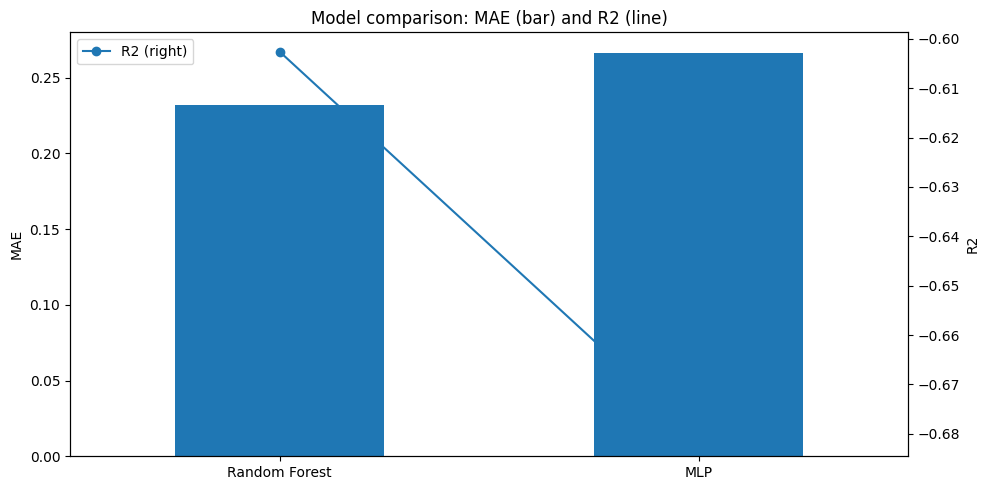

In [11]:
# Evaluation helper and run

def evaluate_model(model, X, y):
    preds = model.predict(X)
    return {
        'MAE': mean_absolute_error(y, preds),
        'R2': r2_score(y, preds)
    }

results = {}
results['Random Forest'] = evaluate_model(rf, X_val, y_val)
if xgb_model is not None:
    results['XGBoost'] = evaluate_model(xgb_model, X_val, y_val)
results['MLP'] = evaluate_model(mlp, X_val, y_val)

results_df = pd.DataFrame(results).T
print(results_df)

# Plot MAE and R2 (R2 on secondary axis)
ax = results_df[['MAE']].plot(kind='bar', figsize=(10,5), legend=False)
results_df[['R2']].plot(kind='line', ax=ax, secondary_y=True, marker='o')
ax.set_ylabel('MAE')
ax.right_ax.set_ylabel('R2')
ax.set_title('Model comparison: MAE (bar) and R2 (line)')
plt.tight_layout()
plt.show()


## Next steps and suggestions

- Add `xgboost` to `requirements.txt` if you want XGBoost in CI and on other machines.
- Add cross-validation and hyperparameter tuning (GridSearchCV or Optuna). 
- Add SHAP or permutation importances to explain model decisions. 
- Create a small `predict_bpm.py` script that loads the best model and serves a prediction API (Flask or FastAPI) for demo purposes.
- Consider adding an interactive Plotly Dash or Voila dashboard to showcase predictions and explainability.

In [4]:
# Diagnostic: check filesystem view from the notebook kernel
import os
from pathlib import Path
print('Notebook cwd:', Path.cwd())
print('Repo root exists:', Path('/home/dobercode/Predicting-the-Beats-per-Minute-of-Songs').exists())
print('data/raw exists:', Path('data/raw').exists())
print('Listing data/raw:')
for i, p in enumerate(sorted(Path('data/raw').glob('*'))[:20]):
    print(i, p.name, p.stat().st_size)

print('Path checks:')
for p in ['data/processed/train_experimental.csv','data/raw/train.csv','/home/dobercode/Predicting-the-Beats-per-Minute-of-Songs/data/raw/train.csv']:
    print(p, Path(p).exists())


Notebook cwd: /home/dobercode/Predicting-the-Beats-per-Minute-of-Songs/notebooks
Repo root exists: True
data/raw exists: False
Listing data/raw:
Path checks:
data/processed/train_experimental.csv False
data/raw/train.csv False
/home/dobercode/Predicting-the-Beats-per-Minute-of-Songs/data/raw/train.csv True
